### Import necessary packages and the scikit-learn diabetes dataset

In [11]:
from sklearn.datasets import load_diabetes
import pandas as pd
import sys
sys.path.append('../')
from tabularmagic import TabularMagic
from tabularmagic.ml import Linear, Tree, TreeEnsemble, SVM, MLP
from tabularmagic.preprocessing.regression_feature_selection import (
    KBestSelector, SimpleLinearSelector)

diabetes_data = load_diabetes()
df = pd.DataFrame(data=diabetes_data.data, columns=diabetes_data.feature_names)
df['target'] = diabetes_data.target
display(df.head())

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


### Create a TabularMagic object

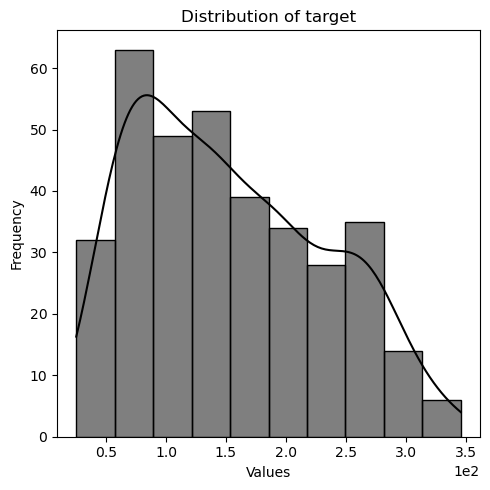

In [12]:
tm = TabularMagic(df, test_size=0.2, random_state=42)
train_eda = tm.eda()
train_eda['target'].plot_distribution()

### Select top 5 features

In [13]:
selectors = [
    KBestSelector('r_regression'),
    SimpleLinearSelector(regularization_type='l1', alpha=0.1),
    SimpleLinearSelector(regularization_type='l2', alpha=0.1)
]
feature_selection_report = tm.voting_selection(X_vars=\
    ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], 
    y_var='target', selectors=selectors, n_target_features=5)
print(feature_selection_report.top_features)

Task 1 of 3.	Fitting KBestSelector(r_regression).
Task 2 of 3.	Fitting LinearSelector(l1, 0.1).
Task 3 of 3.	Fitting LinearSelector(l2, 0.1).
['bmi', 'bp', 's5', 'sex', 's3']


### Scale variables

In [14]:
tm.preprocess_data(minmax_vars=feature_selection_report.top_features + ['target'])

### Basic regression analysis

,OrdinaryLeastSquares(None)
Statistic,
mse,2811.385100
mad,42.809313
pearsonr,0.687948
spearmanr,0.676771
r2,0.469365
adjr2,0.437399


                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     108.9
Date:                Sat, 24 Feb 2024   Prob (F-statistic):           6.83e-69
Time:                        20:57:20   Log-Likelihood:                 126.34
No. Observations:                 353   AIC:                            -240.7
Df Residuals:                     347   BIC:                            -217.5
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0870      0.044      1.961      0.0

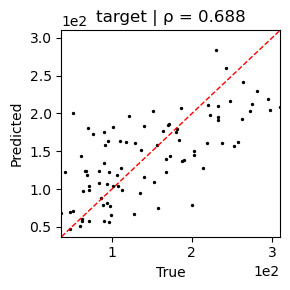

In [15]:
train_report, test_report = tm.ols(X_vars=feature_selection_report.top_features, 
                                   y_var='target')
display(test_report.scorer.to_df())
print(train_report.statsmodels_summary())
test_report.plot_pred_vs_true((3, 3))

### Define a sequence of models

In [16]:
models = [
    # All models have default hyperparameter search methods built in.
    Linear(regularization_type=None, n_jobs=-1),
    Linear(regularization_type='l1', n_jobs=-1),
    Linear(regularization_type='l2', n_jobs=-1),
    Tree(n_jobs=-1, random_state=42, inner_random_state=0),
    TreeEnsemble(ensemble_type='random_forest', n_jobs=-1, random_state=42),
    TreeEnsemble(ensemble_type='bagging', n_jobs=-1),
    TreeEnsemble(ensemble_type='gradient_boosting', n_jobs=-1),
    TreeEnsemble(ensemble_type='xgboost', n_jobs=-1),

    # You can manually set the nickname of a model
    SVM(kernel='rbf', nickname='SupportVectorMachine', n_jobs=-1),
    
    # You can specify the hypeparameter search method in an sklearn-like manner. 
    MLP(
        hyperparam_search_method='grid',
        hyperparam_grid_specification={
            'hidden_layer_sizes': [(50), (100), (50, 50)],
            'activation': ['relu'],
            'solver': ['adam'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'adaptive'],
            'max_iter': [200]
        }
    )
]

### Conduct a benchmarking exercise with the specified models

In [20]:
train_report, test_report = tm.ml_regression_benchmarking(
    X_vars=feature_selection_report.top_features,
    y_var='target',
    models=models,
    outer_cv=5,
)

Task 1 of 10.	Fitting Linear(None).
Task 2 of 10.	Fitting Linear(l1).
Task 3 of 10.	Fitting Linear(l2).
Task 4 of 10.	Fitting Tree.
Task 5 of 10.	Fitting TreeEnsemble(random_forest).
Task 6 of 10.	Fitting TreeEnsemble(bagging).
Task 7 of 10.	Fitting TreeEnsemble(gradient_boosting).
Task 8 of 10.	Fitting TreeEnsemble(xgboost).
Task 9 of 10.	Fitting SupportVectorMachine.
Task 10 of 10.	Fitting MLP.


In [21]:
display(train_report.fit_statistics)

,Linear(None),Linear(l1),Linear(l2),Tree,TreeEnsemble(random_forest),TreeEnsemble(bagging),TreeEnsemble(gradient_boosting),TreeEnsemble(xgboost),SupportVectorMachine,MLP
Statistic,,,,,,,,,,
mse,3070.539211,3064.530429,3059.308412,4318.329424,3401.000362,3404.504624,3343.395176,3434.540091,3105.211403,3057.678820
mad,44.952230,44.955312,44.979664,52.554026,48.337898,47.761107,46.772246,49.393232,45.117868,45.370339
pearsonr,0.706827,0.707062,0.707173,0.584106,0.667093,0.661672,0.675956,0.677676,0.703339,0.705480
spearmanr,0.681905,0.681952,0.681431,0.576402,0.643530,0.646253,0.648544,0.643425,0.674007,0.670628
r2,0.481156,0.482264,0.483714,0.259988,0.429045,0.425309,0.434724,0.422953,0.474304,0.481755
adjr2,1.477614,1.480723,1.487600,0.803497,1.287447,1.260791,1.337204,1.251687,1.450581,1.470331


### View the testing goodness-of-fit statistics

In [22]:
display(train_report.fit_statistics)

,Linear(None),Linear(l1),Linear(l2),Tree,TreeEnsemble(random_forest),TreeEnsemble(bagging),TreeEnsemble(gradient_boosting),TreeEnsemble(xgboost),SupportVectorMachine,MLP
Statistic,,,,,,,,,,
mse,3070.539211,3064.530429,3059.308412,4318.329424,3401.000362,3404.504624,3343.395176,3434.540091,3105.211403,3057.678820
mad,44.952230,44.955312,44.979664,52.554026,48.337898,47.761107,46.772246,49.393232,45.117868,45.370339
pearsonr,0.706827,0.707062,0.707173,0.584106,0.667093,0.661672,0.675956,0.677676,0.703339,0.705480
spearmanr,0.681905,0.681952,0.681431,0.576402,0.643530,0.646253,0.648544,0.643425,0.674007,0.670628
r2,0.481156,0.482264,0.483714,0.259988,0.429045,0.425309,0.434724,0.422953,0.474304,0.481755
adjr2,1.477614,1.480723,1.487600,0.803497,1.287447,1.260791,1.337204,1.251687,1.450581,1.470331


In [23]:
display(test_report.fit_statistics)

,Linear(None),Linear(l1),Linear(l2),Tree,TreeEnsemble(random_forest),TreeEnsemble(bagging),TreeEnsemble(gradient_boosting),TreeEnsemble(xgboost),SupportVectorMachine,MLP
Statistic,,,,,,,,,,
mse,2811.385100,2803.727627,2797.785550,3874.064026,2796.269361,2885.559217,2914.203425,2980.679109,2718.920538,2577.079913
mad,42.809313,42.764741,42.684544,48.028536,43.247711,44.051423,43.285411,45.506756,42.091408,40.843803
pearsonr,0.687948,0.688185,0.688348,0.563543,0.690661,0.674900,0.678559,0.678730,0.700105,0.717262
spearmanr,0.676771,0.679300,0.678542,0.534221,0.673871,0.646909,0.650532,0.668283,0.686918,0.704787
r2,0.469365,0.470810,0.471932,0.268790,0.472218,0.455365,0.449958,0.437412,0.486817,0.513589
adjr2,0.437399,0.438931,0.440120,0.224741,0.440424,0.422556,0.416823,0.403521,0.455903,0.484287


### View the predicted vs true scatter plot of the SVM model on testing data.

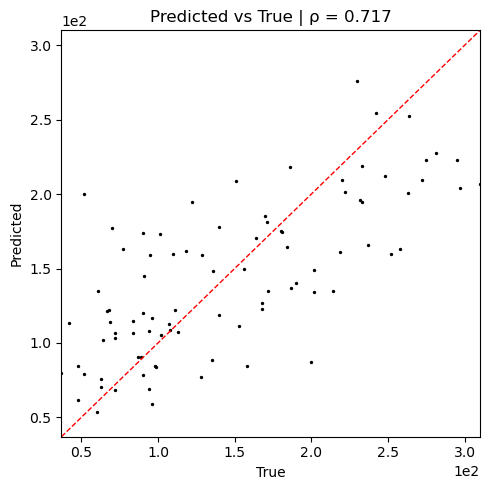

In [33]:
fig = test_report['MLP'].plot_pred_vs_true()
fig

### View the MSE of the random forest model on testing data

In [25]:
print(test_report['MLP'].scorer['mse'])

2577.079912618166
